# Stimulus Design
This notebook will demonstrate how to design a signal that can be used to estimate a channel response. There are a number of stimulus types that can be effective at measuring this response. This analysis will focus on the use of a sweep. It will compare it to the results of using white noise.

In [50]:
%matplotlib inline
#import mpld3
#mpld3.enable_notebook()
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import *
import scipy.signal as signal


The SciPy and Numpy packages will be used for development and analysis.

# Sweep Design

## Stimulus Parameters

In [51]:
Fs = 48000
sweep_low_hz = 17000
sweep_high_hz = 23500.0
sweep_len_sec = 0.2
# Sweep type options: order (>0) noise, hyperbola
sweep_type = 1

noise_level_db = 0 # To measure filter noise rejection

## Generate Stimulus

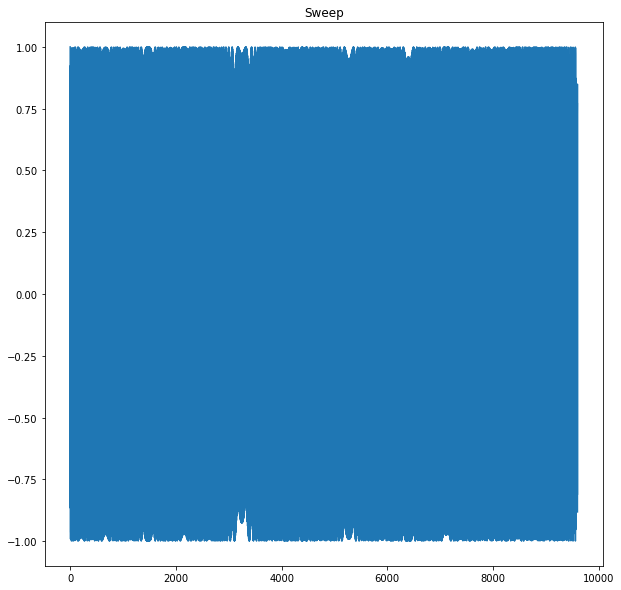

In [52]:
sweep_width_hz = sweep_high_hz-sweep_low_hz
n = np.arange(0,sweep_len_sec*Fs)

# Define the nature of the sweep
if sweep_type == "noise":
    N = 8
    white_noise = np.random.normal(0,1,len(n))
    b,a = signal.butter(N,(sweep_low_hz/(Fs/2),sweep_high_hz/(Fs/2)),btype="bandpass")
    w,h = signal.freqz(b,a)
    plt.figure(figsize=(10,10))
    plt.title("Butterworth filter")
    plt.ylabel("Magnitude [dB]")
    plt.xlabel("Frequency (Hz)")
    plt.plot(w*Fs/(2*np.pi),np.abs(h))
    plt.show()
    sweep = signal.lfilter(b,a,white_noise)
else:
    # Sinusoid - bad variable names acknowledged
    if isinstance(sweep_type,float) or isinstance(sweep_type,int):
        order = int(sweep_type)
        A = np.power(sweep_len_sec,(np.log(sweep_width_hz)/np.log(sweep_len_sec)-order))
        f_n = A*np.power(n/Fs,order)
        k_n = f_n/(Fs)
        baseband_phi_n = 2*np.pi*(np.cumsum(k_n) - k_n[0])
        k_low_hz = sweep_low_hz/Fs
        passband_phi_n = 2*np.pi*k_low_hz*n + baseband_phi_n
        
    elif sweep_type == "hyperbola":
        A = sweep_high_hz*sweep_len_sec / (1 - (sweep_high_hz/sweep_low_hz))
        t = n/(Fs)
        f_n = (sweep_high_hz * sweep_len_sec * sweep_low_hz) / (t * (sweep_low_hz - sweep_high_hz) + sweep_high_hz * sweep_len_sec)
        k_n = f_n/(Fs)
        passband_phi_n = 2*np.pi*(np.cumsum(k_n) - k_n[0])

    sweep = np.cos(passband_phi_n)

plt.figure(figsize=(10,10))
plt.plot(n,sweep)
plt.title("Sweep")
plt.show()

And to verify the sweep signal we can plot a spectrogram:

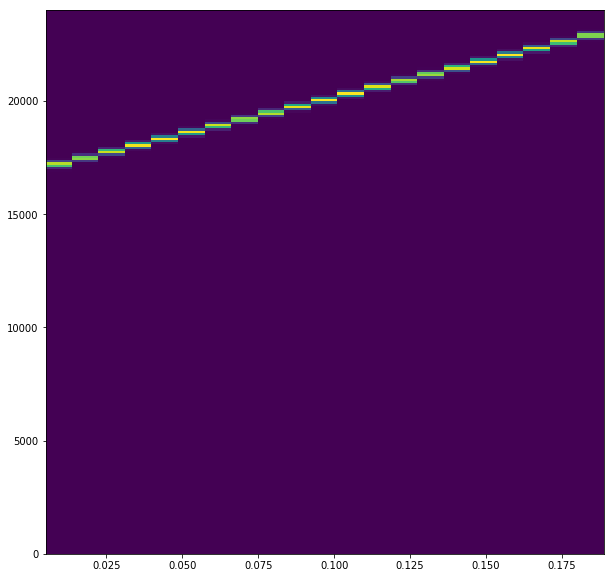

In [53]:
# This is not the window used on the sweep - just to view the spectrum
spectrogram_window = signal.get_window('blackman',int(sweep_len_sec/20*Fs))

f,t,Sxx = signal.spectrogram(sweep,fs=Fs,window=spectrogram_window)
plt.figure(figsize=(10,10))
plt.pcolormesh(t,f,Sxx)
plt.show()

## Performance as a delay estimator using a Matched filter
A matched filter is an ideal filter used to maximise the SNR performance of decoding a signal. A matched filter is essentially an inner product of the transmitted signal with the received signal. In an ideal world there will be no no noise added to the signal and no attenuation or delay, and it's useful to view this as a 'best-case' scenario of the matched filter behaviour.


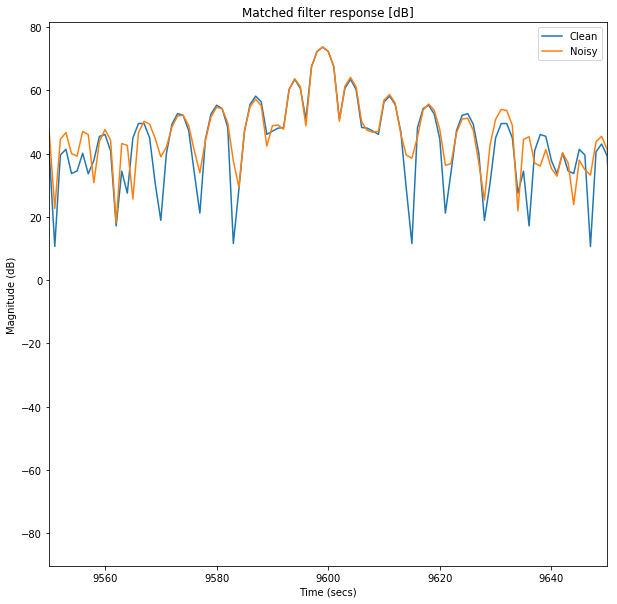

Self rejection [dB] = 10.18
Main lobe width (samples) = 4.000000
Main lobe width (secs) = 0.000083
Main lobe width (metres) = 0.028583
Noise rejection [dB] = 42.32


In [54]:
matched_filter = np.flip(sweep,0)
matched_filter_output = np.convolve(sweep,matched_filter)

# Plot the absolute magnitude of the output
db_abs_out = 20*np.log10(np.abs(matched_filter_output))
fig = plt.figure(figsize=(10,10))
plt.plot(db_abs_out,label="Clean")
plt.xlim([len(sweep)-50,len(sweep)+50])
plt.title("Matched filter response [dB]")
plt.ylabel('Magnitude (dB)')
plt.xlabel('Time (secs)')

noise = np.random.normal(0,np.sqrt(np.power(10,noise_level_db/20)),len(sweep))
noisy_sweep = sweep + noise
noisy_matched_filter_output = np.convolve(noisy_sweep,matched_filter)

db_abs_noisy_out = 20*np.log10(np.abs(noisy_matched_filter_output))
plt.plot(db_abs_noisy_out,label="Noisy")
plt.legend()
plt.show()

# Analysis
# Self rejection
maxima = signal.argrelextrema(db_abs_out,np.greater)
maxima_sorted = np.sort(db_abs_out[maxima])
self_rejection_db = maxima_sorted[-1]-maxima_sorted[-2]

# Main lobe width
location_max = np.where(db_abs_out==maxima_sorted[-1])[0][0]
upper = location_max
while db_abs_out[location_max]-db_abs_out[upper] < 6:
    upper+=1

lower = location_max
while db_abs_out[location_max]-db_abs_out[lower] < 6:
    lower -= 1

main_lobe_width_samples = (upper-lower)
main_lobe_width_sec = main_lobe_width_samples/Fs

# Noise rejection

# Normalise so the main-lobe has the same amplitude as the input signal so noise rejection
# can be measured

# Normalised matched filter output
matched_filter_output_norm = matched_filter_output/np.max(matched_filter_output)
# Normalised noisy matched filter output
noisy_matched_filter_output_norm = noisy_matched_filter_output/np.max(noisy_matched_filter_output)

noise_in_output_mean = np.mean(np.abs(matched_filter_output_norm - noisy_matched_filter_output_norm))
noise_in_output_db = 20*np.log10(noise_in_output_mean)

noise_rejection_db = noise_level_db - noise_in_output_db

print("Self rejection [dB] = %0.2f"%self_rejection_db)
print("Main lobe width (samples) = %f"%main_lobe_width_samples)
print("Main lobe width (secs) = %f"%main_lobe_width_sec)
print("Main lobe width (metres) = %f"%(main_lobe_width_sec*343))
print("Noise rejection [dB] = %0.2f"%noise_rejection_db)


The reported figures above generally demonstrate how resilient the chirp signal is to noise.

**Self rejection** refers to how easily we are able to set detection thresholds when a symbol is received. If the self-rejection is low, it is difficult to distinguish if the symbol arrived at a given time instant or a time instant X samples later. Whn coupled with noise-rejection, this establishes how likely we are to receive spurious peaks that do not correspond to the matched-filter output's main-lobe.

**Noise rejection** refers to the ability of the matched filter to remove noise from the signal.

**Main lobe width** (secs/samples/metres) refers to how distinctly a peak can be detected. I.e. it will refer to time-domain resolution. This should be tuned depending on the certainty required in arrival time esimation.

# Tweaking the stimulus design
In order to tweak the various metrics of our stimulus, we can adjust the following parameters to achieve our desired results:

### Sweep chirp rate
Conclusions:
- Noise rejection performance the longer the length of the chirp sequence.

### Sweep bandwidth
Conclusions:
- Tighter main lobe widths and higher self-rejection can be achieved with a larger signal bandwidth

### Sweep chirp polynomial
Conclusions:
- It appears that main lobe width and self-rejection can be traded-off by configuring the frequency sweep polynomial. However it is clear that the self-rejection becomes severely hindered the larger the polynomial. This makes sense as the matched filter output comes more periodic as the signal itself becomes more consistently periodic.